# Boston Housing Project
## Model Evaluation & Validation
## Project: Predicting Boston Housing Prices

Welcome to the project of Predicting Boston Housing Prices! 

In this project, the performance and the predictive power of a model will be evaluated. The model has been trained and tested on data collected from homes in suburbs of Boston, Massachusetts. A model trained on this data that is seen as a *good fit* could then be used to make certain predictions about a home — in particular, its monetary value. This model would prove to be invaluable for someone like a real estate agent who could make use of such information on a daily basis.

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Housing). The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts. For the purposes of this project, the following preprocessing steps have been made to the dataset:
- 16 data points have an `'MEDV'` value of 50.0. These data points likely contain **missing or censored values** and have been removed.
- 1 data point has an `'RM'` value of 8.78. This data point can be considered an **outlier** and has been removed.
- The features `'RM'`, `'LSTAT'`, `'PTRATIO'`, and `'MEDV'` are essential. The remaining **non-relevant features** have been excluded.
- The feature `'MEDV'` has been **multiplicatively scaled** to account for 35 years of market inflation.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from sklearn.model_selection import ShuffleSplit

# Import supplementary visualizations code visuals.py
import visuals as vs

### Implemented Imports
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

# Pretty display for notebooks
%matplotlib inline

# Load the Boston housing dataset
data = pd.read_csv('housing.csv')
prices = data['MEDV']
features = data.drop('MEDV', axis = 1)
    
# Success
print("Boston housing dataset has {} data points with {} variables each.".format(*data.shape))

Boston housing dataset has 489 data points with 4 variables each.


----

## Data Exploration
In this first section of this project, a cursory investigation and observations about the Boston housing data is provided. 

Familiarizing yourself with the data through an explorative process is a fundamental practice to help you better understand and justify your results.

Since the main goal of this project is to construct a working model which has the capability of predicting the value of houses, dataset separation into **features** and the **target variable** is needed. The **features**, `'RM'`, `'LSTAT'`, and `'PTRATIO'`, give us quantitative information about each data point. The **target variable**, `'MEDV'`, will be the variable we seek to predict. These are stored in `features` and `prices`, respectively.


### Calculate Statistics
Descriptive statistics about the Boston housing prices are calculated below. `numpy` library is used to perform the necessary calculations. These statistics will be extremely important later on to analyze various prediction results from the constructed model.

In the code cell below are the descriptive statistics:
- Calculate the minimum, maximum, mean, median, and standard deviation of `'MEDV'`, which is stored in `prices`.
  - Store each calculation in their respective variable.
  
Descriptive statistics about the Boston housing prices are computed using `numpy` library. These statistics will be extremely important later on to analyze various prediction results from the constructed model.

In the code cell below, the minimum, maximum, mean, median, and standard deviation of `'MEDV'`, which is stored in `prices` are computed.

In [2]:
# Minimum price of the data
minimum_price = np.min(prices)

# Maximum price of the data
maximum_price = np.max(prices)

# Mean price of the data
mean_price = np.mean(prices)

# Median price of the data
median_price = np.median(prices)

# Standard deviation of prices of the data
std_price = np.std(prices)

# Show the calculated statistics
print("Statistics for Boston housing dataset:\n")
print("Minimum price: ${}".format(minimum_price)) 
print("Maximum price: ${}".format(maximum_price))
print("Mean price: ${}".format(mean_price))
print("Median price ${}".format(median_price))
print("Standard deviation of prices: ${}".format(std_price))

Statistics for Boston housing dataset:

Minimum price: $105000.0
Maximum price: $1024800.0
Mean price: $454342.9447852761
Median price $438900.0
Standard deviation of prices: $165171.13154429477


### Feature Observations
As a reminder, three features are used from the Boston housing dataset: `'RM'`, `'LSTAT'`, and `'PTRATIO'`. For each data point (neighborhood):
- `'RM'` is the average number of rooms among homes in the neighborhood.
- `'LSTAT'` is the percentage of homeowners in the neighborhood considered "lower class" (working poor).
- `'PTRATIO'` is the ratio of students to teachers in primary and secondary schools in the neighborhood.

*The following observations are intuitions.*

A house of RM = 6 would be expected to be less worth than a house of RM = 7. Thus the increase of RM should increase MEDV. Indeed, the more rooms there are in the house, the more space you have in the house.

The increase of LSTAT feature should decrease the value of MEDV. Indeed, a low LSTAT percentage means that the neighborhood are in the upper class. This indicates that the environment of the house (playgrounds, roads, stores, parks, etc.) are well maintained. The higher class would be able to pay more taxes for maintenance cost of the area of the house. This would attract people so the price of the house would increase. 

The higher the value of PTRATIO, the lower the value of MEDV. So the increase of PTRATIO would decrease MEDV. People usually don't like classes that are crowded. This could be related to the density of population of the area and people usually don't like high density areas for house. This wouldn't attract people so the prices would decrease.

----

## Developing a Model

The aim of this second section of the project is to develop the tools and techniques necessary for a model to make a prediction. Being able to make accurate evaluations of each model's performance through the use of these tools and techniques helps to greatly reinforce the confidence in the predictions.

### Defining a Performance Metric
It is difficult to measure the quality of a given model without quantifying its performance over training and testing. This is typically done using some type of performance metric, whether it is through calculating some type of error, the goodness of fit, or some other useful measurement. For this project, the [*coefficient of determination*](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination), R<sup>2</sup>, will be calculated to quantify the model's performance. The coefficient of determination for a model is a useful statistic in regression analysis, as it often describes how "good" that model is at making predictions. 

The values for R<sup>2</sup> range from 0 to 1, which captures the percentage of squared correlation between the predicted and actual values of the **target variable**. A model with an R<sup>2</sup> of 0 is no better than a model that always predicts the *mean* of the target variable, whereas a model with an R<sup>2</sup> of 1 perfectly predicts the target variable. Any value between 0 and 1 indicates what percentage of the target variable, using this model, can be explained by the **features**. _A model can be given a negative R<sup>2</sup> as well, which indicates that the model is **arbitrarily worse** than one that always predicts the mean of the target variable._

This `performance_metric` function uses `r2_score` from `sklearn.metrics` to perform a performance calculation between `y_true` and `y_predict`


In [3]:
# Calculate the performance score between 'y_true' and 'y_predict'
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """

    return r2_score(y_true, y_predict)

### Example of Goodness of Fit using the function above
Assume that a dataset contains five data points and a model made the following predictions for the target variable:

| True Value | Prediction |
| :-------------: | :--------: |
| 3.0 | 2.5 |
| -0.5 | 0.0 |
| 2.0 | 2.1 |
| 7.0 | 7.8 |
| 4.2 | 5.3 |

In the code cell below, the `performance_metric` function is used to calculate the model's coefficient of determination.

In [4]:
# Calculate the performance of this model
score = performance_metric([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
print("Model has a coefficient of determination, R^2, of {:.3f}.".format(score))

Model has a coefficient of determination, R^2, of 0.923.


For this example, the model have successfully captured the variation of the target variable. Indeed, the R<sup>2</sup> score is high, 92.3%, this means that the dependent variable, Y, can be predicted mostly from the independent variable, X, chosen for the prediction. 

Recall that the R<sup>2</sup> is the proportion of the variance in the dependent variable that is predictable from the independent variable. In other words:
 
* R<sup>2</sup> score of 0 means that the dependent variable cannot be predicted from the independent variable.
* R<sup>2</sup> score of 1 means the dependent variable can be predicted from the independent variable.
* R<sup>2</sup> score between 0 and 1 indicates the extent to which the dependent variable is predictable. 
* R<sup>2</sup> score of 0.40 means that 40 percent of the variance in Y is predictable from X.

### Shuffle and Split Data

In this sub-section, the Boston Housing dataset is split into training and testing subsets. Typically, the data is also shuffled into a random order when creating the training and testing subsets to remove any bias in the ordering of the dataset.

`train_test_split` from `sklearn.model_selection` is used to shuffle and split the `features` and `prices` data into training and testing sets. The data is split as 80% for the training dataset and 20% for the testing dataset. 

The `random_state` for `train_test_split` is set to 42 (it can be any value) to ensure that the results are consistent. The train and testing splits are assigned to `X_train`, `X_test`, `y_train`, and `y_test`.

In [5]:
# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size = 0.20, shuffle = True, random_state = 42)

# Success
print("Training and testing split was successful.")

Training and testing split was successful.


### Training and Testing

The benefit of splitting a dataset into some ratio of training and testing sets for a learning algorithm is to be able to prevent overfitting or underfitting. Indeed, when training the algorithm on a training set, the algorithm tends to overfit those datas. So in order to see if our algorithm is doing correctly, we try it on the same smaller dataset, the testing set in order to see how is our model is doing (overfitting or underfitting).


----

## Analyzing Model Performance

In this third section of the project, several model's learning and testing performances are considered. The models are applied to various subsets of training data.

Additionally, a particular algorithm with an increasing `'max_depth'` parameter is investigated on the full training set to observe how model complexity affects performance. 
Graphing model's performances based on varying criteria can be beneficial in the analysis process, such as visualizing behavior that may not have been apparent from the results alone.

### Learning Curves

The following code cell produces four graphs for a decision tree model with different maximum depths. Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased. Note that the shaded region of a learning curve denotes the uncertainty of that curve (measured as the standard deviation). The model is scored on both the training and testing sets using R<sup>2</sup>, the coefficient of determination.  


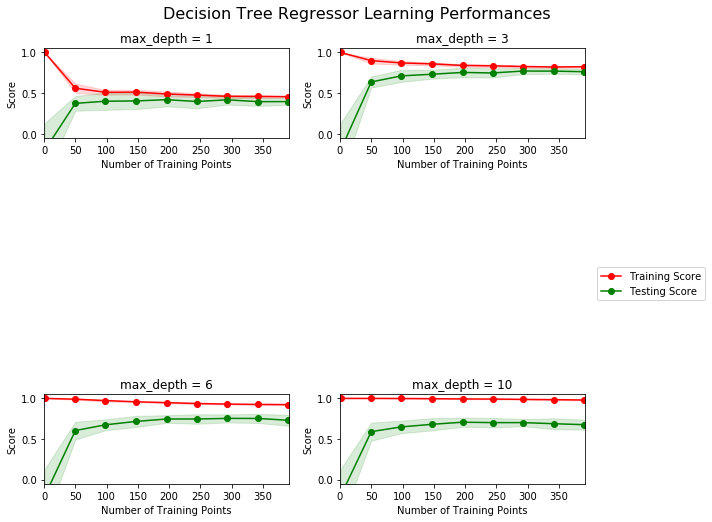

In [6]:
# Produce learning curves for varying training set sizes and maximum depths
vs.ModelLearning(features, prices)

### Learning the Data

The graph with a maximum depth of 10 is considered here. The higher the score, the lower the error. So as the score of the training set stays close to 1, one can guess an overfitting on the training set. If the points of training set is increaed, the score would decrease only by a tiny amount, but in general it would stay as it is.  

The overfitting with the curve of the testing set can be confirmed. Indeed, it doesn't converge with the curve of the training set even if the number of training points is rising. It would even, decrease the score of the testing set as the model is overfitted on the training set.

Increasing the number of training set wouldn't benefit the model as there is an overfitting case. This would increase the error (so the testing score would decrease) on the testing set thus the curves won't converge. Also the shaded regions are very small in this graph which confirm the overfitting aspect of this case.

### Complexity Curves
The following code cell produces a graph for a decision tree model that has been trained and validated on the training data using different maximum depths. The graph produces two complexity curves — one for training and one for validation. Similar to the **learning curves**, the shaded regions of both the complexity curves denote the uncertainty in those curves, and the model is scored on both the training and validation sets using the `performance_metric` function.  

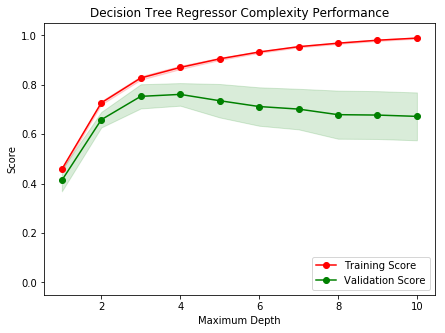

In [7]:
vs.ModelComplexity(X_train, y_train)

### Bias-Variance Tradeoff

High bias is a sign of underfitting(model is not complex enough to pick up the nuances in the data) and high variance is a sign of overfitting(model is by-hearting the data and cannot generalize well). Think about which model(depth 1 or 10) aligns with which part of the tradeoff.

When the model is trained with a maximum depth of 1, the model suffer from high bias. In this case, it is an underfitting model. There are large amount of misclassified points on the training and testing sets as the model underfit the datas.

When the model is trained with a maximum depth of 10, the model suffer from high variance. The visual cues in the graph I used is the big gap between the training score graph and the cross validation score graph. Indeed, as it is an overfitting model, there are fewer errors on the training set (high score), and more errors in the validation score (smaller score).

### Best-Guess Optimal Model

By observing the graph given by the `vs.ModelComplexity(X_train, y_train)` above, one can affirm that the maximum depth of 4 generalizes best unseen datas. Indeed, that is where the highest score for the validation set is (lowest error).

Also, the graph of learning curve indicates a maximum depth of higher 3 or more, but less than 6. Because, the deeper the depth is, the lower the score of the testing curve stabilises which indicates higher error. And with a max_depth of 6, the testing curve stabilizes at a lower score than a max_depth of 3.

And remember, Occams Razor states "Among competing hypotheses, the one with the fewest assumptions should be selected."

-----

## Evaluating Model Performance

In this final section of the project, a model is constructed and make a prediction on the client's feature set using an optimized model from `fit_model`.

### Grid Search

A Grid Search is a grid where we confront 2 (or more) parameters against each other in order to find the best parameters for a model. This optimizes a learning algorithm by using them.

For instance, we can confront the kernel ('poly','rbf') and the gamma (0.1, 1, 10) parameters  for an SVM and compute the f1_score for each combination: 

| kernel | gamma |
| :----: | :----: |
| poly | 0.1 |
| poly | 1.0 |
| poly | 10.0 |
| rbf | 0.1 |
| rbf | 1.0 |
| rbf | 10.0 |

When the lowest f1_score is found, the corresponding parameters for the model for optimization is used. One would then be confident that these parameters would have lower the error.

### Cross-Validation

The K-fold cross-validation training technique is a method to recycle our data. 

The K stands for the number of bins we separate our data. For instance, our data set size is 200, and K = 10 bins, then in each bin, we have 20 data per bin.
We use 1 bin as the testing bin and the remaining K-1 bins are put together into the training set. We then train our data with this data configuration.

And then another testing bin (a different one each time) is chosen and training is done again. This is reapeated K times and the result of K-fold validation is the average of the results obtained on each set. 

This techniques enable to use all our data for training and all our data for testing, thus recycling our data. 

The benefit this technique provide for grid search when optimizing a model is that it gets rid of the variance problem that arrises. Indeed, a different accuracy on one test compared to another test set using the same algorithm appears. K-fold CV prevent that. Thus, it helps grid search by only having one accuracy instead of K different accuracies.

Ressource on Cross-Validation is in the [doc](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation).


### Implementation: Fitting a Model

The final implementation requires to bring everything together and train a model using the **decision tree algorithm**. To ensure that an optimized model is produced, the model is trained using the grid search technique to optimize the `'max_depth'` parameter for the decision tree. The `'max_depth'` parameter can be thought of as how many questions the decision tree algorithm is allowed to ask about the data before making a prediction. Decision trees are part of a class of algorithms called *supervised learning algorithms*.

In addition, `ShuffleSplit()` is used for an alternative form of cross-validation (see the `'cv_sets'` variable). While it is not the K-Fold cross-validation technique described above, this type of cross-validation technique is just as useful!. The `ShuffleSplit()` implementation below creates 10 (`'n_splits'`) shuffled sets, and for each shuffle, 20% (`'test_size'`) of the data will be used as the *validation set*. 

[`DecisionTreeRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) from `sklearn.tree` is used to create a decision tree regressor object. The object is assigned to the `'regressor'` variable.

A dictionary for `'max_depth'` with the values from 1 to 10 is creat4ed, and assigned to the `'params'` variable.

[`make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) from `sklearn.metrics` is used to create a scoring function object. The `performance_metric` function is passed as a parameter to the object. This scoring function is assigned to the `'scoring_fnc'` variable.

[`GridSearchCV`](http://scikit-learn.org/0.20/modules/generated/sklearn.model_selection.GridSearchCV.html) from `sklearn.model_selection` is used to create a grid search object. The variables `'regressor'`, `'params'`, `'scoring_fnc'`, and `'cv_sets'` are passed as parameters to the object. The `GridSearchCV` object is assined to the `'grid'` variable.


In [8]:
def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Creation of cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 0)

    # Creation of a decision tree regressor object
    regressor = DecisionTreeRegressor()

    # Creation of a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth':[1,2,3,4,5,6,7,8,9,10]}

    # Transformation of 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Creation of the grid search cv object --> GridSearchCV()
    # Make sure to include the right parameters in the object:
    # (estimator, param_grid, scoring, cv) which have values 'regressor', 'params', 'scoring_fnc', and 'cv_sets' respectively.
    grid = GridSearchCV(estimator = regressor, param_grid = params, scoring = scoring_fnc, cv = cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

### Making Predictions
Once a model has been trained on a given set of data, it can now be used to make predictions on new sets of input data. In the case of a *decision tree regressor*, the model has learned *what the best questions to ask about the input data are*, and can respond with a prediction for the **target variable**. One can use these predictions to gain information about data where the value of the target variable is unknown — such as data the model was not trained on.

In [9]:
# Fitting the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))

Parameter 'max_depth' is 4 for the optimal model.


### Optimal Model

The code block above fit the decision tree regressor to the training data and produce anoptimal model.

The maximum depth the **optimal model** have is 4 which corresponds to the *guessed* maximum depth above. It is also congruent to the fact that it was higher than 3 but less than 6.

### Question 10 - Predicting Selling Prices
Imagine a real estate agent in the Boston area is looking to use this model to help price homes owned by several clients that they wish to sell. The following informations have been collected from three clients:

| Feature | Client 1 | Client 2 | Client 3 |
| :---: | :---: | :---: | :---: |
| Total number of rooms in home | 5 rooms | 4 rooms | 8 rooms |
| Neighborhood poverty level (as %) | 17% | 32% | 3% |
| Student-teacher ratio of nearby schools | 15-to-1 | 22-to-1 | 12-to-1 |

Of the three clients, client 3 has has the biggest house, in the best public school neighborhood with the lowest poverty level; while client 2 has the smallest house, in a neighborhood with a relatively high poverty rate and not the best public schools.

Run the code block below to have the optimized model make predictions for each client's home.


In [10]:
# Produce a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3

# Show predictions
for i, price in enumerate(reg.predict(client_data)):
    print("Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price))

Predicted selling price for Client 1's home: $403,025.00
Predicted selling price for Client 2's home: $237,478.72
Predicted selling price for Client 3's home: $931,636.36


Predicted selling price for Client 1's home: $403,025.00

Predicted selling price for Client 2's home: $237,478.72

Predicted selling price for Client 3's home: $931,636.36

The prices seem reasonable given their respective features. Also, the explanation given in the Data Exploration matches the order and the "prices" of the houses predicted. 

Client 1: The model predicted for a house with 5 rooms, 17\% of neighborhood of poverty and a 15-1 student-teacher ratio is $403,025.00. 
The 3 features are in between the client 2 and client 3 feature's, which is correctly classified as so in its predicted selling price.

Client 2: The model predicted for a house with 4 rooms, 32\% of neighborhood of poverty and a 2-1 student-teacher ratio is $237,478.72.
This has the lowest predicted price. It can be explained with its low amount of rooms, its high percentage of neighborhood poverty and its high ratio of student-teacher. In the overall, this house wouldn't be that expensive as its features all tends to decrease its price.

Client 3: The model predicted for a house with 8 rooms, 3\% of neighborhood of poverty and a 12-1 student-teacher ratio is $931,636.36.
This has the higher predicted price. Contrary to client 2, the features of client 3 tends to push upward its predicted price. Indeed, it has a high amount of rooms, a very low percentage of neighborhood poverty and a very low student-teacher ratio.


### Sensitivity
An optimal model is not necessarily a robust model. Sometimes, a model is either too complex or too simple to sufficiently generalize to new data. Sometimes, a model could use a learning algorithm that is not appropriate for the structure of the data given. Other times, the data itself could be too noisy or contain too few samples to allow a model to adequately capture the target variable — i.e., the model is underfitted. 

**The code cell below runs the `fit_model` function ten times with different training and testing sets to see how the prediction for a specific client changes with respect to the data it's trained on.**


In [11]:
vs.PredictTrials(features, prices, fit_model, client_data)

Trial 1: $391,183.33
Trial 2: $424,935.00
Trial 3: $415,800.00
Trial 4: $420,622.22
Trial 5: $418,377.27
Trial 6: $411,931.58
Trial 7: $399,663.16
Trial 8: $407,232.00
Trial 9: $351,577.61
Trial 10: $413,700.00

Range in prices: $73,357.39


### Applicability

The range calculated is a little more than 70,000.00$ which is a big amount already. This can be explained by the fact that the data collected from 1978 is not relevant for today's market. Inflation is important here and should be taken in account. 
The features present in the data is not enough to describe a home. We need more different and independent features, like if there's a garden, parking lot, square feet, presence of a pool, how many floors there are, and so on. 
The model isn't robust enough to make consistent predictions. For instance, the data collected in an urban city wouldn't be applicable in a rural city, because of the different set of features those two areas would have. 
